## 텐서플로 분류 모델 만들기
* [첫 번째 신경망 훈련하기: 기초적인 분류 문제  |  TensorFlow Core](https://www.tensorflow.org/tutorials/keras/classification)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 데이터셋을 불러옵니다.
df = pd.read_csv("http://bit.ly/data-diabetes-csv")
df.shape

(768, 9)

In [3]:
# 미리보기를 합니다.
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 전체 수치변수 시각화 

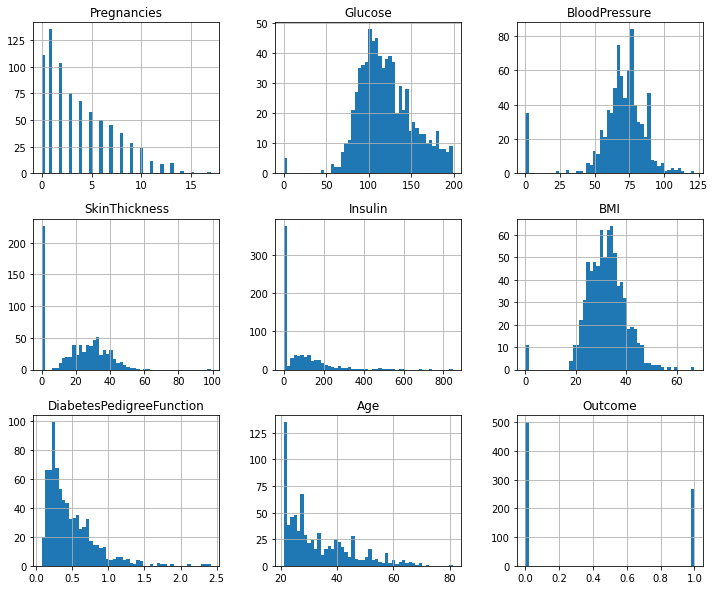

In [4]:
# 히스토그램으로 시각화 합니다.
df.hist(figsize=(12, 10), bins=50);

In [5]:
# describe 로 요약합니다.
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 데이터 전처리
### 인슐린의 0을 다른 값으로 대체하기

In [6]:
# Insulin 이 0 인 값을 다른 값으로 대체하기
df["Insulin_nan"] = df["Insulin"].replace(0, np.nan)

In [7]:
# 당뇨병 여부에 따라 groupby로 인슐린의 중앙값 구하기
insulin_median = df.groupby("Outcome")["Insulin_nan"].median()
insulin_median

Outcome
0    102.5
1    169.5
Name: Insulin_nan, dtype: float64

In [8]:
# 변수에 할당한 값 확인하기
df["Insulin_fill"] = df["Insulin_nan"]

In [9]:
# 당뇨병 여부에 따라 인슐린값 대체하기
df.loc[(df["Outcome"] == 0) & (df["Insulin_nan"].isnull()) , "Insulin_fill"] = insulin_median[0]
df.loc[(df["Outcome"] == 1) & (df["Insulin_nan"].isnull()) , "Insulin_fill"] = insulin_median[1]

In [10]:
df.groupby("Outcome")["Insulin_fill"].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,500.0,117.172000,75.685302,15.0,95.0,102.5,105.0,744.0
1,268.0,187.615672,94.114420,14.0,169.5,169.5,169.5,846.0


## 데이터셋 나누기

In [11]:
# label_name
label_name = "Outcome"
label_name

'Outcome'

In [12]:
# X, y 만들기
X = df.drop(columns=[label_name, "Insulin_nan", "Insulin"])
y = df[label_name]
X.shape, y.shape

((768, 8), (768,))

In [13]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Insulin_fill
0,6,148,72,35,33.6,0.627,50,169.5
1,1,85,66,29,26.6,0.351,31,102.5
2,8,183,64,0,23.3,0.672,32,169.5
3,1,89,66,23,28.1,0.167,21,94.0
4,0,137,40,35,43.1,2.288,33,168.0


In [14]:
# sklearn.model_selection 으로 데이터셋 나누기
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42)

<img src="https://cs231n.github.io/assets/nn1/neural_net.jpeg" width="30%"> <img src="https://cs231n.github.io/assets/nn1/neural_net2.jpeg" width="40%">

* 이미지 출처 : https://cs231n.github.io/neural-networks-1/

## 딥러닝 레이어 만들기

* [첫 번째 신경망 훈련하기: 기초적인 분류 문제  |  TensorFlow Core](https://www.tensorflow.org/tutorials/keras/classification)

* 층 설정
    * 신경망의 기본 구성 요소는 층(layer)입니다. 
    * 층은 주입된 데이터에서 표현을 추출합니다. 
    * 대부분 딥러닝은 간단한 층을 연결하여 구성됩니다. 
    * tf.keras.layers.Dense와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됩니다.

* Dense Layer: 
    * 밀집 연결(densely-connected) 또는 완전 연결(fully-connected) 층이라고 부릅니다. 
    * 첫 번째 Dense 층은 128개의 노드(또는 뉴런)를 가집니다. 
    * 마지막 층은 출력층 입니다.
        * 소프트맥스 일 때 : 2개의 노드의 소프트맥스(softmax) 층입니다. 이 층은 2개의 확률을 반환하고 반환된 값의 전체 합은 1입니다. 
        * 각 노드는 현재 이미지가 2개 클래스 중 하나에 속할 확률을 출력합니다.
        * 시그모이드 일 때 : 둘 중 하나를 예측할 때 1개의 출력값을 출력합니다. 확률을 받아 임계값 기준으로 True, False로 나눕니다.
        * 분류 예측 값이 둘 중 하나일 때 : tf.keras.layers.Dense(1, activation='sigmoid
    * 출력층 :
        * 분류 예측 값이 n개 일 때 :  tf.keras.layers.Dense(n, activation='softmax')
        * 분류 예측 값이 둘 중 하나일 때 : tf.keras.layers.Dense(1, activation='sigmoid')
        * 회귀 예측 일 때 : tf.keras.layers.Dense(1, activation='linear')

    
    
* 드롭아웃(dropout)은 신경망에서 가장 효과적이고 널리 사용하는 규제 기법 중 하나입니다. 토론토(Toronto) 대학의 힌튼(Hinton)과 그의 제자들이 개발했습니다. 드롭아웃을 층에 적용하면 훈련하는 동안 층의 출력 특성을 랜덤하게 끕니다(즉, 0으로 만듭니다). 훈련하는 동안 어떤 입력 샘플에 대해 [0.2, 0.5, 1.3, 0.8, 1.1] 벡터를 출력하는 층이 있다고 가정해 보죠. 드롭아웃을 적용하면 이 벡터에서 몇 개의 원소가 랜덤하게 0이 됩니다. 예를 들면, [0, 0.5, 1.3, 0, 1.1]가 됩니다. "드롭아웃 비율"은 0이 되는 특성의 비율입니다. 보통 0.2에서 0.5 사이를 사용합니다. 테스트 단계에서는 어떤 유닛도 드롭아웃하지 않습니다. 훈련 단계보다 더 많은 유닛이 활성화되기 때문에 균형을 맞추기 위해 층의 출력 값을 드롭아웃 비율만큼 줄입니다.

* tf.keras에서는 Dropout 층을 이용해 네트워크에 드롭아웃을 추가할 수 있습니다. 이 층은 바로 이전 층의 출력에 드롭아웃을 적용합니다. (https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)

In [15]:
# tensorflow 를 tf로 불러오기

import tensorflow as tf

## 활성화 함수 activations

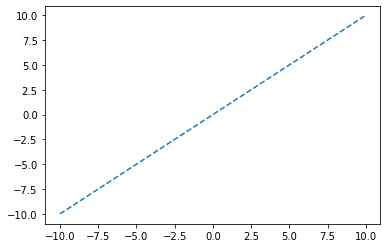

In [16]:
x = np.arange(-10, 10, 0.1)
plt.plot(x, x, linestyle='--', label="x") 

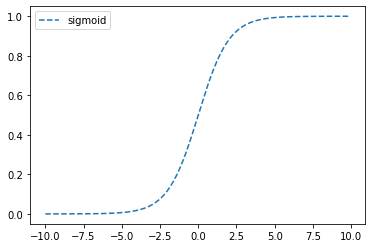

In [17]:
# tf.keras.activations.sigmoid(x)
# x축은 원래 값을 y축은 sigmoid 함수를 통과시킨 값입니다. 
plt.plot(x, tf.keras.activations.sigmoid(x), linestyle='--', label="sigmoid") 
plt.legend()

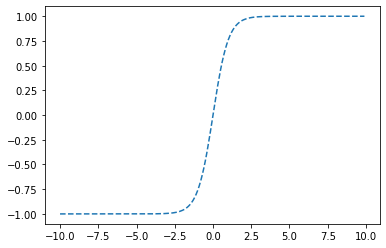

In [18]:
# tf.keras.activations.tanh(x)
plt.plot(x, tf.keras.activations.tanh(x), linestyle='--', label="tanh") 

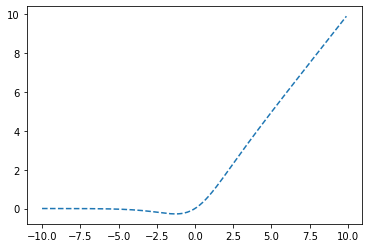

In [19]:
# swish
plt.plot(x, tf.keras.activations.swish(x), linestyle='--', label="swish") 

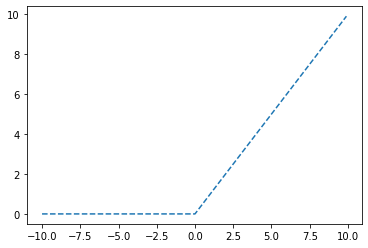

In [20]:
# relu
plt.plot(x, tf.keras.activations.relu(x), linestyle='--', label="relu") 

In [21]:
print(dir(tf.keras.activations))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'deserialize', 'elu', 'exponential', 'gelu', 'get', 'hard_sigmoid', 'linear', 'relu', 'selu', 'serialize', 'sigmoid', 'softmax', 'softplus', 'softsign', 'swish', 'tanh']


In [22]:
input_shape = len(X_train.keys())
input_shape

8

In [23]:
input_shape = X_train.shape[1]
input_shape

8

In [325]:
# 입력-히든-출력(sigmoid) 레이어로 구성
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=256, activation='selu', input_shape=[input_shape]),
    tf.keras.layers.Dense(units=128, activation='selu'),
    tf.keras.layers.Dense(units=128, activation='selu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=64, activation='selu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),         
])
model

### 모델 컴파일
모델을 훈련하기 전에 필요한 몇 가지 설정이 모델 컴파일 단계에서 추가됩니다:

* 옵티마이저(Optimizer) - 데이터와 손실 함수를 바탕으로 모델의 업데이트 방법을 결정합니다.
* 지표(Metrics) - 훈련 단계와 테스트 단계를 모니터링하기 위해 사용합니다. 다음 예에서는 올바르게 분류된 이미지의 비율인 정확도를 사용합니다.


* 손실 함수(Loss function) - 훈련 하는 동안 모델의 오차를 측정합니다. 모델의 학습이 올바른 방향으로 향하도록 이 함수를 최소화해야 합니다. 최적의 가중치를 찾도록 해야함
    * 회귀  : MSE, MAE
    * 분류 : 
        * 바이너리(예측할 값의 종류가 둘 중 하나) : 
            * binary_crossentropy
        * 멀티클래스(예측할 값의 종류가 2개 이상) : 
            * categorical crossentropy(one-hot형태의 클래스 예: [0, 1, 0, 0])
            * sparse categorical crossentropy(정답값이 0, 1, 2, 3, 4 와 같은 형태일 때)

In [326]:
# 모델 컴파일
model.compile(optimizer="adam", 
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [327]:
# 모델 요약
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_103 (Dense)           (None, 256)               2304      
                                                                 
 dense_104 (Dense)           (None, 128)               32896     
                                                                 
 dense_105 (Dense)           (None, 128)               16512     
                                                                 
 dropout_38 (Dropout)        (None, 128)               0         
                                                                 
 dense_106 (Dense)           (None, 64)                8256      
                                                                 
 dropout_39 (Dropout)        (None, 64)                0         
                                                                 
 dense_107 (Dense)           (None, 1)               

## 학습
* 배치(batch): 모델 학습에 한 번에 입력할 데이터셋
* 에폭(epoch): 모델 학습시 전체 데이터를 학습한 횟 수
* 스텝(step): (모델 학습의 경우) 하나의 배치를 학습한 횟 수

In [338]:
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

In [339]:
# 학습하기
history = model.fit(X_train, y_train, epochs=1000, validation_split=0.2, 
                    callbacks=[early_stop, PrintDot()], verbose=0)
history


........................................

In [340]:
# 학습결과의 history 값을 가져와서 비교하기 위해 데이터프레임으로 변환
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,accuracy,val_loss,val_accuracy
35,0.308890,0.859470,0.233609,0.869919
36,0.310206,0.859470,0.257825,0.886179
37,0.292125,0.873727,0.262507,0.894309
38,0.320368,0.849287,0.255343,0.878049
39,0.292501,0.849287,0.265621,0.886179


### 학습결과 시각화 

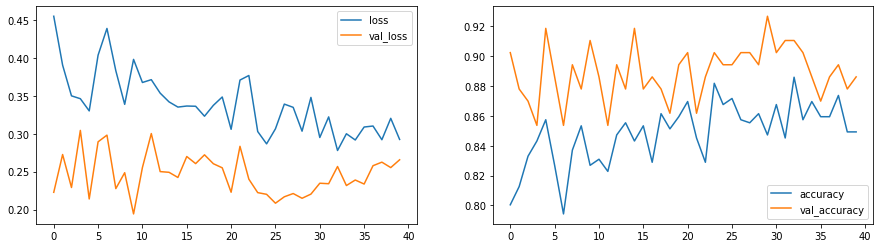

In [341]:
# loss, accuracy 값 시각화 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
df_hist[["loss", "val_loss"]].plot(ax=axes[0])
df_hist[["accuracy", "val_accuracy"]].plot(ax=axes[1])

## 예측

In [342]:
# 예측값을 y_pred 변수에 할당 후 재사용합니다.
y_pred = model.predict(X_test).flatten()
y_pred.shape

5/5 [==============================] - 0s 2ms/step


(154,)

In [343]:
y_pred.round(2)

array([0.48, 0.02, 0.  , 0.  , 0.  , 0.98, 0.  , 0.  , 0.36, 0.  , 0.52,
       0.21, 0.16, 0.  , 0.  , 0.47, 0.01, 0.  , 1.  , 0.25, 0.  , 0.  ,
       0.09, 0.01, 0.23, 0.85, 0.04, 0.  , 0.02, 0.  , 0.45, 1.  , 0.55,
       1.  , 0.  , 0.69, 0.92, 0.3 , 0.  , 1.  , 0.  , 0.  , 0.  , 1.  ,
       0.  , 0.26, 0.8 , 0.03, 0.  , 0.96, 0.  , 0.75, 0.73, 0.97, 0.07,
       0.  , 0.  , 0.  , 0.06, 1.  , 0.74, 0.07, 0.99, 0.95, 0.  , 0.17,
       0.  , 0.96, 0.  , 0.27, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.08, 0.07, 0.  , 1.  , 0.  , 0.  , 0.15, 0.03, 0.97, 0.76, 0.14,
       0.01, 0.  , 0.01, 0.  , 0.  , 1.  , 0.53, 0.17, 0.  , 0.  , 0.17,
       0.  , 0.07, 0.  , 1.  , 0.53, 1.  , 0.16, 0.24, 0.8 , 0.  , 0.81,
       0.01, 0.01, 0.  , 0.82, 0.09, 0.07, 0.78, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.23, 0.  , 0.  , 0.91, 0.94, 0.69, 1.  , 0.47, 1.  , 0.58,
       0.05, 0.27, 0.31, 0.  , 0.96, 0.74, 0.4 , 0.  , 0.01, 0.  , 0.  ,
       0.19, 0.  , 0.  , 0.13, 0.  , 0.07, 1.  , 0.

In [344]:
# 예측값 시각화
# 임계값을 정해서 특정값 이상이면 True, 아니면 False로 변환해서 사용할 예정입니다.
y_predict = (y_pred > 0.5).astype(int)
y_predict

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

## 평가

In [345]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\n테스트 정확도:', test_acc)

5/5 [==============================] - 0s 3ms/step - loss: 0.4890 - accuracy: 0.8377

테스트 정확도: 0.8376623392105103


In [346]:
# argmax는 다차원 배열의 차원에 따라 가장 큰 값의 인덱스들을 반환해주는 함수
# 출력층에서 softmax 사용 시 확률로 반환되기 때문에 그 중 가장 높은 값의 인덱스를 찾을 때 사용
# y_predict = np.argmax(y_pred, axis=1)
# 출력층 sigmoid 사용 시 flatten 을 통해 예측값을 1차원으로 변환
# 0.5 이상의 값을 True 로 하고 int32 타입으로 변경
# y_predict

In [347]:
# 직접 정확도 측정하기
(y_test == y_predict).mean()

0.8376623376623377